

## **Deep Learning in Biomedicine**
#### **Final Project:** Classification of Chest X-ray Images and Patient Metadata Using Multi-Modal Model
**Team 4**: Alexander Sternfeld, Silvia Romanato and Antoine Bonnet



In [2]:
from data import *
from models import *
from train import *

%reload_ext autoreload
%autoreload 2


## 1. **Data**

### 1.1. **Tabular data**

[MIMIC-IV Documentation](https://mimic.mit.edu/docs/iv/). 

**Tables that we use**

* `Admissions`
* `Patients`
* `Services`


**Tables that could be used:**
* `emar`
* `d_hcpcs.csv.gz`
* `hpcsevents`
* `labevents`
* `microbiologyevents`



In [3]:
CLASS_FREQUENCIES = {
    'Atelectasis': {0.0: 171692, 2.0: 45808, 1.0: 10327},
    'Cardiomegaly': {0.0: 176939, 2.0: 44845, 1.0: 6043},
    'Consolidation': {0.0: 212718, 2.0: 10778, 1.0: 4331},
    'Edema': {0.0: 187635, 2.0: 27018, 1.0: 13174},
    'Enlarged Cardiomediastinum': {0.0: 211273, 1.0: 9375, 2.0: 7179},
    'Fracture': {0.0: 222882, 2.0: 4390, 1.0: 555},
    'Lung Lesion': {0.0: 220402, 2.0: 6284, 1.0: 1141},
    'Lung Opacity': {0.0: 172471, 2.0: 51525, 1.0: 3831},
    'No Finding': {0.0: 152372, 2.0: 75455, 1.0: 0},
    'Pleural Effusion': {0.0: 167713, 2.0: 54300, 1.0: 5814},
    'Pleural Other': {0.0: 225051, 2.0: 2011, 1.0: 765},
    'Pneumonia': {0.0: 192980, 1.0: 18291, 2.0: 16556},
    'Pneumothorax': {0.0: 216335, 2.0: 10358, 1.0: 1134},
    'Support Devices': {0.0: 161032, 2.0: 66558, 1.0: 237}
    }

# Sum up the frequencies of each class
TOTAL_FREQUENCIES = {}
for class_name, frequencies in CLASS_FREQUENCIES.items():
    for label, frequency in frequencies.items():
        if label not in TOTAL_FREQUENCIES:
            TOTAL_FREQUENCIES[label] = 0
        TOTAL_FREQUENCIES[label] += frequency

TOTAL_FREQUENCIES

{0.0: 2691495, 2.0: 423065, 1.0: 75018}

In [4]:
CLASS_FREQUENCIES = {
    'Atelectasis': {0.0: 171692, 2.0: 45808, 1.0: 10327},
    'Cardiomegaly': {0.0: 176939, 2.0: 44845, 1.0: 6043},
    'Consolidation': {0.0: 212718, 2.0: 10778, 1.0: 4331},
    'Edema': {0.0: 187635, 2.0: 27018, 1.0: 13174},
    'Enlarged Cardiomediastinum': {0.0: 211273, 1.0: 9375, 2.0: 7179},
    'Fracture': {0.0: 222882, 2.0: 4390, 1.0: 555},
    'Lung Lesion': {0.0: 220402, 2.0: 6284, 1.0: 1141},
    'Lung Opacity': {0.0: 172471, 2.0: 51525, 1.0: 3831},
    'No Finding': {0.0: 152372, 2.0: 75455, 1.0: 0},
    'Pleural Effusion': {0.0: 167713, 2.0: 54300, 1.0: 5814},
    'Pleural Other': {0.0: 225051, 2.0: 2011, 1.0: 765},
    'Pneumonia': {0.0: 192980, 1.0: 18291, 2.0: 16556},
    'Pneumothorax': {0.0: 216335, 2.0: 10358, 1.0: 1134},
    'Support Devices': {0.0: 161032, 2.0: 66558, 1.0: 237}
    }

# Sum up frequencies over all diseases for each class
TOTAL_FREQUENCIES = {}
for class_name, frequencies in CLASS_FREQUENCIES.items():
    for label, frequency in frequencies.items():
        if label not in TOTAL_FREQUENCIES:
            TOTAL_FREQUENCIES[label] = 0
        TOTAL_FREQUENCIES[label] += frequency
TOTAL_FREQUENCIES

{0.0: 2691495, 2.0: 423065, 1.0: 75018}

In [100]:
# Normalize TOTAL_FREQUENCIES to get class weights
CLASS_WEIGHTS = {}
for label, frequency in TOTAL_FREQUENCIES.items():
    CLASS_WEIGHTS[label] = frequency / sum(TOTAL_FREQUENCIES.values())
CLASS_WEIGHTS

{0.0: 0.8438404704321387, 2.0: 0.1326398037608737, 1.0: 0.02351972580698763}

In [111]:
1/(0.02351972580698763+0.1326398037608737)

6.403707815765645

In [112]:
FREQUENCIES = [0.8438404704321387, 0.02351972580698763, 0.1326398037608737]
POSITIVE_NEUTRAL_FREQ = sum(FREQUENCIES[1:])
NEG_FREQ = FREQUENCIES[0]

CLASS_WEIGHT = [
    1/NEG_FREQ,
    1/POSITIVE_NEUTRAL_FREQ,
    1/POSITIVE_NEUTRAL_FREQ
]

[1.185058118257697, 6.403707815765645, 6.403707815765645]

In [ ]:

# Compute the average frequency of each class for all diseases
CLASS_FREQUENCIES_AVG = {}
for class_name, frequencies in CLASS_FREQUENCIES.items():
    for val, freq in frequencies.items():
        if val not in CLASS_FREQUENCIES_AVG:
            CLASS_FREQUENCIES_AVG[val] = 0
        CLASS_FREQUENCIES_AVG[val] += freq / len(CLASS_FREQUENCIES)

# Normalize the frequencies
freqs = list(CLASS_FREQUENCIES_AVG.values())
freqs /= np.sum(freqs)
freqs


In [ ]:
POS_NEUT_FRACTION = freqs[2]
pos_neutral_weight = 1/POS_NEUT_FRACTION
neg_weight = 1/(1-POS_NEUT_FRACTION)
weights = [neg_weight, pos_neutral_weight, pos_neutral_weight]  / np.sum([neg_weight, pos_neutral_weight, pos_neutral_weight])
weights


In [ ]:


class_weights = []
for disease in CLASS_FREQUENCIES:
    freqs = CLASS_FREQUENCIES[disease]
    weights = [
        1/freqs[0.0],
        1/(freqs[1.0] + freqs[2.0]),
        1/(freqs[1.0] + freqs[2.0])
    ]
    class_weights.append(weights)
class_weights = np.array(class_weights)
class_weights = class_weights / class_weights.sum(axis=1, keepdims=True)
class_weights = torch.from_numpy(class_weights).float()
class_weights

In [24]:
def diagnosis(logits): 
    '''
    Given a logits tensor of size (batch_size, num_classes, num_labels),
    returns a diagnosis matrix of size (batch_size, num_classes, num_labels)
    where each entry is 1 if it is the argmax of labels for that class, and 0 otherwise.
    '''
    diagnosis = torch.argmax(logits, dim=-1)
    diagnosis = F.one_hot(diagnosis, num_classes=logits.shape[-1])
    return diagnosis

logits = torch.tensor([
    [[0.123, 0.789, 0.456], [0.321, 0.654, 0.987], [.789, 0.456, .123], [0.321, 0.654, 0.987], [0.123, 0.456, 0.789], [0.321, 0.654, 0.987], [0.123, 0.456, 0.789], [0.321, 0.654, 0.987], [0.123, 0.456, 0.789], [0.321, 0.654, 0.987], [0.123, 0.456, 0.789], [0.321, 0.654, 0.987], [0.123, 0.456, 0.789], [0.321, 0.654, 0.987]],
    [[0.123, 0.456, 0.789], [0.321, 0.654, 0.987], [0.123, 0.456, 0.789], [0.321, 0.654, 0.987], [0.123, 0.456, 0.789], [0.321, 0.654, 0.987], [0.123, 0.456, 0.789], [0.321, 0.654, 0.987], [0.123, 0.456, 0.789], [0.321, 0.654, 0.987], [0.123, 0.456, 0.789], [0.321, 0.654, 0.987], [0.123, 0.456, 0.789], [0.321, 0.654, 0.987]],
    ], dtype=torch.float)
logits = logits / logits.sum(axis=-1, keepdims=True)

labels = torch.tensor(
    [[[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0], [0, 1, 0]],
     [[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0], [0, 1, 0]]
     ], dtype=torch.float)


preds = diagnosis(logits)
preds = torch.argmax(torch.tensor(preds), dim=-1)
labels = torch.argmax(torch.tensor(labels), dim=-1)

print('Preds:', preds)
print('Labels:', labels)

metrics = {}
metrics = {}
for i, (disease, freqs) in enumerate(CLASS_FREQUENCIES.items()):
    print('Logits: ', logits[:, i, :])
    inv_freqs = np.array([0 if x == 0 else 1/x for x in freqs.values()])
    inv_freqs = inv_freqs / inv_freqs.sum()
    metrics['acc_'+disease] = balanced_accuracy_score(labels[:, i], preds[:, i])
    metrics['macroF1_'+disease] = f1_score(labels[:, i], preds[:, i], average='macro')
    metrics['wF1_'+disease] = f1_score(labels[:, i], preds[:, i], average='weighted')
    metrics['wAUC_'+disease] = roc_auc_score(labels[:, i], logits[:, i, :], average='weighted', multi_class='ovr', labels=[0, 1, 2])

Preds: tensor([[1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
Labels: tensor([[0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1],
        [0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1]])
Logits:  tensor([[0.0899, 0.5768, 0.3333],
        [0.0899, 0.3333, 0.5768]])


/Users/abonnet/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/abonnet/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


ValueError: Only one class present in y_true. ROC AUC score is not defined in that case.

In [73]:
inv_freqs = np.array([0 if x == 0 else 1/x for x in freqs.values()])
inv_freqs = inv_freqs / inv_freqs.sum()
inv_freqs

array([0.02921793, 0.11528132, 0.85550075])

In [ ]:
self.class_weights = []
        for i, freqs in enumerate(CLASS_FREQUENCIES.values()):
            inv_freqs = [1/freqs[x] for x in range(len(freqs)) if freqs[x] > 0 else 0]
            self.class_weights.append(inv_freqs)

In [ ]:
tabular = preprocess_tabular()
tabular

Loading:	Pre-processed tabular data from ../data/processed_data/tab_data_total.csv.


,subject_id,study_id,anchor_age,MED,ORTHO,GU,CMED,OBS,PSYCH,ENT,...,gender_M,anchor_year_group_2008 - 2010,anchor_year_group_2011 - 2013,anchor_year_group_2014 - 2016,anchor_year_group_2008 - 2010.1,anchor_year_group_2011 - 2013.1,anchor_year_group_2014 - 2016.1,insurance_Medicaid,insurance_Medicare,insurance_Other
0,17744443,56580856,29.0,0,0,0,1,0,0,0,...,1,0,1,0,0,1,0,0,0,1
1,19298916,50189753,66.0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
2,12139024,53153436,53.0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
3,18763864,51105845,45.0,0,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,1
4,12799312,56469369,40.0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33341,15243252,50214443,31.0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
33342,13271160,54593756,84.0,0,0,0,0,0,0,0,...,1,1,0,0,1,0,0,0,1,0
33343,15403581,53793119,79.0,0,0,0,1,0,0,0,...,1,1,0,0,1,0,0,0,1,0
33344,14361828,51569492,70.0,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0


### 1.2. **Labels**

Note that "No Finding" is the absence of any of the 13 descriptive labels and a check that the text does not mention a specified set of other common findings beyond those covered by the descriptive labels. Each label column contains one of four values: 1.0, -1.0, 0.0, or missing. These labels have the following interpretation:

* **1.0** - The label was positively mentioned in the associated study, and is present in one or more of the corresponding images e.g. "A large pleural effusion"
* **0.0** - The label was negatively mentioned in the associated study, and therefore should not be present in any of the corresponding images e.g. "No pneumothorax."
* **-1.0** - The label was either: (1) Explicit uncertainty or (2) Ambiguous language
* **Missing** (empty element) - No mention of the label was made in the report

In [ ]:
labels = preprocess_labels()
labels

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
1,10000032,53189527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
2,10000032,53911762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
3,10000032,56699142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
4,10000764,57375967,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227822,19999442,58708861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0
227823,19999733,57132437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
227824,19999987,55368167,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
227825,19999987,58621812,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


#### **Labels**: Exploratory analysis

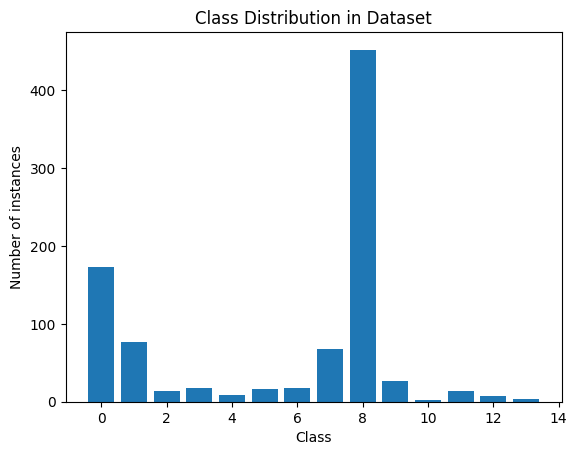

In [ ]:
import torch
from collections import Counter
import matplotlib.pyplot as plt

class_counts = {8: 452, 0: 173, 1: 77, 7: 68, 9: 27, 6: 17, 3: 17, 
                5: 16, 11: 14, 2: 14, 4: 9, 12: 7, 13: 3, 10: 2}

# Plot the class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Number of instances')
plt.title('Class Distribution in Dataset')
plt.show()

By this distrbution we can see that the data is imbalanced. We will use the `class_weight` on the cross-entropy loss to account for this. <br>
Other possibilities are: 
1. **Resampling Your Dataset**:
Oversampling the Minority Class: Increase the number of instances of underrepresented classes in your training set. This can be done by duplicating existing instances or generating synthetic instances (e.g., using SMOTE).
Undersampling the Majority Class: Reduce the number of instances of overrepresented classes.
2. **Data Augmentation**:
Apply data augmentation techniques to the minority class to create synthetic data points. This is especially useful in image and audio processing tasks.
3. **Change the Evaluation Metric**:
Use evaluation metrics like F1-score, precision-recall curve, ROC AUC, etc., which give a better sense of model performance on imbalanced datasets.

### **Data preparation**

In [ ]:
import pickle

if os.path.exists('tab_data.pickle'):
    with open('tab_data.pickle', 'rb') as handle:
        tab_data = pickle.load(handle)
    with open('image_data.pickle', 'rb') as handle:
        image_data = pickle.load(handle)

else: 
    tab_data, image_data = prepare_data()

    # Save tab_data
    with open('tab_data.pickle', 'wb') as handle:
        pickle.dump(tab_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open('image_data.pickle', 'wb') as handle:
        pickle.dump(image_data, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [1]:
CLASS_FREQUENCIES = {
    'Atelectasis': {0.0: 171692, 2.0: 45808, 1.0: 10327},
    'Cardiomegaly': {0.0: 176939, 2.0: 44845, 1.0: 6043},
    'Consolidation': {0.0: 212718, 2.0: 10778, 1.0: 4331},
    'Edema': {0.0: 187635, 2.0: 27018, 1.0: 13174},
    'Enlarged Cardiomediastinum': {0.0: 211273, 1.0: 9375, 2.0: 7179},
    'Fracture': {0.0: 222882, 2.0: 4390, 1.0: 555},
    'Lung Lesion': {0.0: 220402, 2.0: 6284, 1.0: 1141},
    'Lung Opacity': {0.0: 172471, 2.0: 51525, 1.0: 3831},
    'No Finding': {0.0: 152372, 2.0: 75455, 1.0: 0.00001},
    'Pleural Effusion': {0.0: 167713, 2.0: 54300, 1.0: 5814},
    'Pleural Other': {0.0: 225051, 2.0: 2011, 1.0: 765},
    'Pneumonia': {0.0: 192980, 1.0: 18291, 2.0: 16556},
    'Pneumothorax': {0.0: 216335, 2.0: 10358, 1.0: 1134},
    'Support Devices': {0.0: 161032, 2.0: 66558, 1.0: 237}}
class_weights = torch.tensor([1/x for x in CLASS_FREQUENCIES])
class_weights


NameError: name 'torch' is not defined

### **Data augmentation**

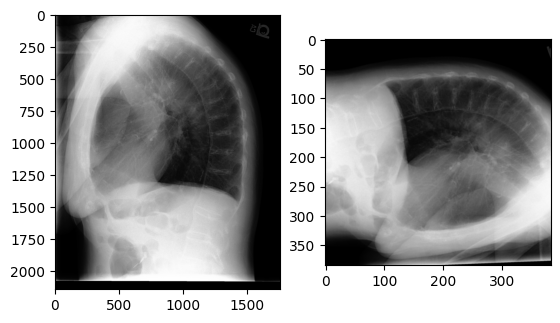

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
vision = 'vit'
with open('../data/mimic-cxr/files/p10/p10001122/s53447138/832b57d8-3ae08663-e152699e-51c5db98-b7cb4226.jpg', 'rb') as f:
    img = Image.open(f)
    img = img.convert('RGB')
    transforms = transform_image(img.size, vision=vision, augment=True)
    transf_img = transforms(img)
    if vision != 'vit':
        transf_img = transf_img.transpose(0, 2).transpose(0, 1) # Transpose to (H, W, C)
        
    # Plot both images side by side
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img)
    ax[1].imshow(transf_img)
    plt.show()


## 2. **Models**



Here is a table with the models we will train:
| Model | Vision | Tabular |
| --- | --- | --- |
| 1 | - | FCN | 
| 2 | ResNet50 (CNN) | FCN | 
| 3 | ResNet50 (CNN) | - |
| 4 | DenseNet (CNN) | FCN | 
| 5 | DenseNet (CNN) | - | 
| 6 | Vision Transformer (ViT) | FCN | 
| 7 | Vision Transformer (ViT)| - | 

We use the same fully-connected network (FCN) for all models. 





### 2.1. **Fully-Connected Network (FCN)**

In [ ]:
grid_search(tabular=True, 
            vision=None, 
            hidden_dims=[256, 512], 
            dropout_prob=0.0, 
            batch_norm=True,
            lr=1e-4, 
            num_epochs=10,
            seed=0)

Model initialization
	Tabular encoder with parameters: {'dim_input': 87, 'hidden_dims': [256, 512], 'dropout_prob': 0.0, 'batch_norm': True}
W&B initialization: run Tabular-256-512-p0.0


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


LOADING DATA (vision: None)
Loaded image data:	Train: 184	Validation: 14	Test: 30 samples.
Loaded tabular data: 	Train: 92	Validation: 7	Test: 15 samples.
Created datasets:	Train: 92	Validation: 7	Test: 15 samples.
Moving model to device: cpu


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/transformers/optimization.py:415: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/230 [00:00<?, ?it/s]

{'loss': 12.3496, 'learning_rate': 2.0000000000000002e-07, 'epoch': 0.04}
{'loss': 12.3769, 'learning_rate': 4.6e-06, 'epoch': 1.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 12.32276439666748, 'eval_Atelectasis': 0.0, 'eval_Cardiomegaly': 0.2857142857142857, 'eval_Consolidation': 0.0, 'eval_Edema': 0.42857142857142855, 'eval_Enlarged Cardiomediastinum': 0.8571428571428571, 'eval_Fracture': 0.0, 'eval_Lung Lesion': 0.0, 'eval_Lung Opacity': 0.14285714285714285, 'eval_No Finding': 0.7142857142857143, 'eval_Pleural Effusion': 0.5714285714285714, 'eval_Pleural Other': 1.0, 'eval_Pneumonia': 0.0, 'eval_Pneumothorax': 1.0, 'eval_Support Devices': 0.0, 'eval_Average': 0.35714285714285715, 'eval_runtime': 0.3792, 'eval_samples_per_second': 18.458, 'eval_steps_per_second': 18.458, 'epoch': 1.0}
{'loss': 12.3755, 'learning_rate': 9.2e-06, 'epoch': 2.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 12.325959205627441, 'eval_Atelectasis': 0.0, 'eval_Cardiomegaly': 0.2857142857142857, 'eval_Consolidation': 0.0, 'eval_Edema': 0.2857142857142857, 'eval_Enlarged Cardiomediastinum': 0.8571428571428571, 'eval_Fracture': 0.0, 'eval_Lung Lesion': 0.0, 'eval_Lung Opacity': 0.0, 'eval_No Finding': 0.7142857142857143, 'eval_Pleural Effusion': 0.7142857142857143, 'eval_Pleural Other': 1.0, 'eval_Pneumonia': 0.0, 'eval_Pneumothorax': 1.0, 'eval_Support Devices': 0.0, 'eval_Average': 0.34693877551020413, 'eval_runtime': 0.0981, 'eval_samples_per_second': 71.388, 'eval_steps_per_second': 71.388, 'epoch': 2.0}
{'loss': 12.378, 'learning_rate': 1.3800000000000002e-05, 'epoch': 3.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 12.324637413024902, 'eval_Atelectasis': 0.0, 'eval_Cardiomegaly': 0.2857142857142857, 'eval_Consolidation': 0.0, 'eval_Edema': 0.2857142857142857, 'eval_Enlarged Cardiomediastinum': 0.8571428571428571, 'eval_Fracture': 0.0, 'eval_Lung Lesion': 0.0, 'eval_Lung Opacity': 0.0, 'eval_No Finding': 0.7142857142857143, 'eval_Pleural Effusion': 0.7142857142857143, 'eval_Pleural Other': 1.0, 'eval_Pneumonia': 0.0, 'eval_Pneumothorax': 1.0, 'eval_Support Devices': 0.0, 'eval_Average': 0.34693877551020413, 'eval_runtime': 0.0931, 'eval_samples_per_second': 75.19, 'eval_steps_per_second': 75.19, 'epoch': 3.0}
{'loss': 12.3758, 'learning_rate': 1.84e-05, 'epoch': 4.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 12.327069282531738, 'eval_Atelectasis': 0.0, 'eval_Cardiomegaly': 0.2857142857142857, 'eval_Consolidation': 0.0, 'eval_Edema': 0.14285714285714285, 'eval_Enlarged Cardiomediastinum': 0.8571428571428571, 'eval_Fracture': 0.0, 'eval_Lung Lesion': 0.0, 'eval_Lung Opacity': 0.0, 'eval_No Finding': 0.7142857142857143, 'eval_Pleural Effusion': 0.7142857142857143, 'eval_Pleural Other': 1.0, 'eval_Pneumonia': 0.0, 'eval_Pneumothorax': 1.0, 'eval_Support Devices': 0.0, 'eval_Average': 0.336734693877551, 'eval_runtime': 0.0956, 'eval_samples_per_second': 73.22, 'eval_steps_per_second': 73.22, 'epoch': 4.0}
{'loss': 12.3758, 'learning_rate': 2.3000000000000003e-05, 'epoch': 5.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 12.327590942382812, 'eval_Atelectasis': 0.0, 'eval_Cardiomegaly': 0.2857142857142857, 'eval_Consolidation': 0.0, 'eval_Edema': 0.2857142857142857, 'eval_Enlarged Cardiomediastinum': 0.8571428571428571, 'eval_Fracture': 0.0, 'eval_Lung Lesion': 0.0, 'eval_Lung Opacity': 0.0, 'eval_No Finding': 0.7142857142857143, 'eval_Pleural Effusion': 0.5714285714285714, 'eval_Pleural Other': 1.0, 'eval_Pneumonia': 0.0, 'eval_Pneumothorax': 1.0, 'eval_Support Devices': 0.0, 'eval_Average': 0.336734693877551, 'eval_runtime': 0.0943, 'eval_samples_per_second': 74.242, 'eval_steps_per_second': 74.242, 'epoch': 5.0}
{'loss': 12.3767, 'learning_rate': 2.7600000000000003e-05, 'epoch': 6.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 12.32564640045166, 'eval_Atelectasis': 0.0, 'eval_Cardiomegaly': 0.2857142857142857, 'eval_Consolidation': 0.0, 'eval_Edema': 0.42857142857142855, 'eval_Enlarged Cardiomediastinum': 0.8571428571428571, 'eval_Fracture': 0.0, 'eval_Lung Lesion': 0.0, 'eval_Lung Opacity': 0.0, 'eval_No Finding': 0.7142857142857143, 'eval_Pleural Effusion': 0.7142857142857143, 'eval_Pleural Other': 1.0, 'eval_Pneumonia': 0.0, 'eval_Pneumothorax': 1.0, 'eval_Support Devices': 0.0, 'eval_Average': 0.35714285714285715, 'eval_runtime': 0.1064, 'eval_samples_per_second': 65.764, 'eval_steps_per_second': 65.764, 'epoch': 6.0}
{'loss': 12.3758, 'learning_rate': 3.2200000000000003e-05, 'epoch': 7.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 12.323290824890137, 'eval_Atelectasis': 0.0, 'eval_Cardiomegaly': 0.2857142857142857, 'eval_Consolidation': 0.0, 'eval_Edema': 0.42857142857142855, 'eval_Enlarged Cardiomediastinum': 0.8571428571428571, 'eval_Fracture': 0.0, 'eval_Lung Lesion': 0.0, 'eval_Lung Opacity': 0.0, 'eval_No Finding': 0.5714285714285714, 'eval_Pleural Effusion': 0.5714285714285714, 'eval_Pleural Other': 1.0, 'eval_Pneumonia': 0.0, 'eval_Pneumothorax': 1.0, 'eval_Support Devices': 0.0, 'eval_Average': 0.33673469387755095, 'eval_runtime': 0.0924, 'eval_samples_per_second': 75.764, 'eval_steps_per_second': 75.764, 'epoch': 7.0}
{'loss': 12.3748, 'learning_rate': 3.68e-05, 'epoch': 8.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 12.325182914733887, 'eval_Atelectasis': 0.0, 'eval_Cardiomegaly': 0.2857142857142857, 'eval_Consolidation': 0.0, 'eval_Edema': 0.2857142857142857, 'eval_Enlarged Cardiomediastinum': 0.8571428571428571, 'eval_Fracture': 0.0, 'eval_Lung Lesion': 0.0, 'eval_Lung Opacity': 0.0, 'eval_No Finding': 0.7142857142857143, 'eval_Pleural Effusion': 0.5714285714285714, 'eval_Pleural Other': 1.0, 'eval_Pneumonia': 0.0, 'eval_Pneumothorax': 1.0, 'eval_Support Devices': 0.0, 'eval_Average': 0.336734693877551, 'eval_runtime': 0.0996, 'eval_samples_per_second': 70.254, 'eval_steps_per_second': 70.254, 'epoch': 8.0}
{'loss': 12.3751, 'learning_rate': 4.14e-05, 'epoch': 9.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 12.3258695602417, 'eval_Atelectasis': 0.0, 'eval_Cardiomegaly': 0.2857142857142857, 'eval_Consolidation': 0.0, 'eval_Edema': 0.2857142857142857, 'eval_Enlarged Cardiomediastinum': 0.8571428571428571, 'eval_Fracture': 0.0, 'eval_Lung Lesion': 0.0, 'eval_Lung Opacity': 0.0, 'eval_No Finding': 0.7142857142857143, 'eval_Pleural Effusion': 0.7142857142857143, 'eval_Pleural Other': 1.0, 'eval_Pneumonia': 0.0, 'eval_Pneumothorax': 1.0, 'eval_Support Devices': 0.0, 'eval_Average': 0.34693877551020413, 'eval_runtime': 0.0941, 'eval_samples_per_second': 74.421, 'eval_steps_per_second': 74.421, 'epoch': 9.0}
{'loss': 12.3744, 'learning_rate': 4.600000000000001e-05, 'epoch': 10.0}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 12.323716163635254, 'eval_Atelectasis': 0.0, 'eval_Cardiomegaly': 0.2857142857142857, 'eval_Consolidation': 0.0, 'eval_Edema': 0.2857142857142857, 'eval_Enlarged Cardiomediastinum': 0.8571428571428571, 'eval_Fracture': 0.0, 'eval_Lung Lesion': 0.0, 'eval_Lung Opacity': 0.0, 'eval_No Finding': 0.5714285714285714, 'eval_Pleural Effusion': 0.5714285714285714, 'eval_Pleural Other': 1.0, 'eval_Pneumonia': 0.0, 'eval_Pneumothorax': 1.0, 'eval_Support Devices': 0.0, 'eval_Average': 0.32653061224489793, 'eval_runtime': 0.1016, 'eval_samples_per_second': 68.906, 'eval_steps_per_second': 68.906, 'epoch': 10.0}
{'train_runtime': 8.4353, 'train_samples_per_second': 109.065, 'train_steps_per_second': 27.266, 'train_loss': 12.375738977349323, 'epoch': 10.0}


  0%|          | 0/15 [00:00<?, ?it/s]

{'eval_loss': 12.389037132263184,
 'eval_Atelectasis': 0.0,
 'eval_Cardiomegaly': 0.06666666666666667,
 'eval_Consolidation': 0.0,
 'eval_Edema': 0.0,
 'eval_Enlarged Cardiomediastinum': 1.0,
 'eval_Fracture': 0.0,
 'eval_Lung Lesion': 0.0,
 'eval_Lung Opacity': 0.4666666666666667,
 'eval_No Finding': 0.13333333333333333,
 'eval_Pleural Effusion': 1.0,
 'eval_Pleural Other': 1.0,
 'eval_Pneumonia': 0.0,
 'eval_Pneumothorax': 1.0,
 'eval_Support Devices': 0.0,
 'eval_Average': 0.3333333333333333,
 'eval_runtime': 0.2772,
 'eval_samples_per_second': 54.119,
 'eval_steps_per_second': 54.119,
 'epoch': 10.0}

### 2.2. **ResNet50 (CNN)**

In [2]:
grid_search(tabular=True, 
            vision='vit', 
            hidden_dims=[256, 512], 
            dropout_prob=0.0, 
            batch_norm=True,
            lr=1e-4, 
            num_epochs=10,
            seed=0)

Model initialization
	Vision encoder: vit
	Tabular encoder with parameters: {'dim_input': 87, 'hidden_dims': [256, 512], 'dropout_prob': 0.0, 'batch_norm': True}
W&B initialization: run Tabular-vit-256-512-p0.0
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
LOADING DATA (vision: vit)
Loaded image data:	Train: 520	Validation: 62	Test: 74 samples.
Loaded tabular data: 	Train: 260	Validation: 31	Test: 37 samples.
Created datasets:	Train: 260	Validation: 31	Test: 37 samples.
Moving model to device: cpu


/Users/silviaromanato/.conda/envs/lastenv/lib/python3.8/site-packages/transformers/training_args.py:1843: UserWarning: `use_mps_device` is deprecated and will be removed in version 5.0 of 🤗 Transformers. `mps` device will be used by default if available similar to the way `cuda` device is used.Therefore, no action from user is required. 
  warnings.warn(


  0%|          | 0/330 [00:00<?, ?it/s]

{'loss': 12.3221, 'learning_rate': 9.96969696969697e-05, 'epoch': 0.03}


KeyboardInterrupt: 

### 2.3. **DenseNet (CNN)**

- https://github.com/liuzhuang13/DenseNet
- https://huggingface.co/docs/timm/models/densenet

In [ ]:
train_data, val_data, test_data = load_data(tab_data, image_data, vision='densenet121')

LOADING DATA (vision: densenet121)
Loaded image data:	Train: 202	Validation: 16	Test: 31 samples.
Loaded tabular data: 	Train: 95	Validation: 8	Test: 15 samples.
Created datasets:	Train: 92	Validation: 7	Test: 15 samples.


In [ ]:
model = JointEncoder(
    tabular=True, 
    tabular_params=tabular_params,
    vision='densenet121'
)
model

JointEncoder(
  (vision_encoder): DualVisionEncoder(
    (model_pa): Sequential(
      (0): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2):

### 2.4. **Vision Transformer** (ViT)

- **Input**: 224x224x3 image. 
- **Preprocessing**: Split the image into 16x16 patches, flatten them into 1D vectors, and add a learnable position embedding to each patch.
- **Output**: 768-dimensional vector for each image. 

In [ ]:
train_data, val_data, test_data = load_data(tab_data, image_data, vision='vit')

LOADING DATA (vision: vit)
Loaded image data:	Train: 202	Validation: 16	Test: 31 samples.
Loaded tabular data: 	Train: 95	Validation: 8	Test: 15 samples.
Created datasets:	Train: 92	Validation: 7	Test: 15 samples.


In [ ]:
test_dataloader(train_data)

x_pa:	torch.Size([4, 384, 384, 3])
x_lat:	torch.Size([4, 384, 384, 3])
x_tab:	torch.Size([4, 87])
label:	torch.Size([4, 14, 3])


In [ ]:
model = JointEncoder(
    tabular=True, 
    tabular_params=tabular_params,
    vision='vit'
)
model

### **Wasted code**

In [ ]:
num_epochs = 2

class_counts = {8: 452, 0: 173, 1: 77, 7: 68, 9: 27, 6: 17, 3: 17, 
                5: 16, 11: 14, 2: 14, 4: 9, 12: 7, 13: 3, 10: 2}
class_weights = 1. / torch.tensor(list(class_counts.values()), dtype=torch.float)
print('The class weights are: ', class_weights)

model = DualInputModel(model='densenet121', num_classes=14)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_model(model, num_epochs, train_dataloader, criterion, optimizer, device, verbose = False)
test_model(model, test_dataloader, device)
torch.save(model.state_dict(), 'model.pth')

In [ ]:
# EXAMPLE OF VIT IMAGE PROCESSING
from transformers import ViTImageProcessor, ViTForImageClassification
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

In [ ]:
# PROBABLY DEPRECATED
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = train_model(model, num_epochs, train_dataloader, criterion, optimizer, device, verbose = False)
model = test_model(model, test_dataloader, device)
torch.save(model.state_dict(), 'model.pth')